In [2]:
import pickle
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Embedding, TimeDistributed, Dense, Flatten, Conv1D, Activation, RepeatVector, Permute, Multiply, Lambda, Bidirectional, LSTM

from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
pickle_path = 'pickle/'

In [4]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
#methods to preprocess the data and labels

#encode the sentences with max length of max_sentence_length
def pad_encode_sentences(df):
    df = df.groupby('story_id').agg({'sentence':','.join})
    pad_enc_sentences = []
    for sentences in tqdm(list(df.sentence)):
        enc_sent = [[word2idx.get(w,1) for w in sent.split()[:max_sentence_length]] for sent in sentences.split(',')]
        if len(enc_sent) < max_story_length:
            enc_sent.extend([[0 for p in range(max_sentence_length)] for i in range(max_story_length - len(enc_sent))])
        padded_sen = tf.keras.preprocessing.sequence.pad_sequences(enc_sent,maxlen = max_sentence_length,padding='post',truncating='post')
        pad_enc_sentences.append(padded_sen)
    return pad_enc_sentences

#pad the labels with max length of story
def pad_labels(df):
    dfx = df.copy()
    dfx['label'] = dfx['label'] + 1
    dfx = dfx[['story_id','label']].groupby('story_id').agg(lambda col: col.tolist()).reset_index()
    labels = tf.keras.preprocessing.sequence.pad_sequences(list(dfx.label),maxlen = max_story_length, padding='post',truncating='post')
    labels = labels.reshape(-1, max_story_length, 1)
    return labels

In [11]:
#load the intermediate stored earlier
with open(pickle_path + 'word2idx.pkl','rb') as fl:
  word2idx = pickle.load(fl)

with open(pickle_path + 'idx2word.pkl','rb') as fl:
  idx2word = pickle.load(fl)

with open(pickle_path + 'label2idx.pkl','rb') as fl:
  label2idx = pickle.load(fl)

with open(pickle_path + 'padded_data_train.pkl','rb') as fl:
  x_train = pickle.load(fl)

with open(pickle_path + 'padded_labels_train.pkl','rb') as fl:
  y_train = pickle.load(fl)

with open(pickle_path + 'padded_data_val.pkl','rb') as fl:
  x_val = pickle.load(fl)

with open(pickle_path + 'padded_labels_val.pkl','rb') as fl:
  y_val = pickle.load(fl)

with open(pickle_path + 'padded_data_test.pkl','rb') as fl:
  x_test = pickle.load(fl)

with open(pickle_path + 'padded_labels_test.pkl','rb') as fl:
  y_test = pickle.load(fl)

In [12]:
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(30000, 29, 40) (10000, 29, 40) (10000, 29, 40)
(30000, 29, 1) (10000, 29, 1) (10000, 29, 1)


In [13]:
max_story_length = x_train.shape[1]
max_sentence_length = x_train.shape[2]
vocab_size = len(word2idx)

print(max_story_length , max_sentence_length, vocab_size)

29 40 166677


In [14]:
def get_embedding(embedding_path):
  glove_embeddings = {}
  embedding_dim = 100
  with open('glove.6B.100d.txt') as fl:
    ln = fl.readline().split()
    word = ln[0]
    emb = np.array(ln[1:],dtype='float32')
    glove_embeddings[word] = emb
  
  embedding = np.zeros((len(word2idx),embedding_dim))

  for idx, key in enumerate(word2idx):
    if glove_embeddings.get(key) is not None:
      embedding[idx,:] = glove_embeddings[word]

  return embedding

In [16]:
embedding_path = 'glove.6B.100d.txt'
embedding_matrix = get_embedding(embedding_path)
embedding_dim = 100

In [17]:
#create the model using attention
inp = Input(shape=(max_story_length , max_sentence_length,))
emb = TimeDistributed(Embedding(input_dim = len(word2idx),
                                output_dim = embedding_dim,
                                input_length = max_sentence_length,
                                weights = [embedding],
                                trainable = True))(inp)
conv1d = TimeDistributed(Conv1D(filters = 32, kernel_size = 2, activation = 'relu',padding='same'))(emb)

dense1 = TimeDistributed(Dense(units = 1, activation='tanh'))(conv1d)
flat = TimeDistributed(Flatten())(dense1)
activation1 = TimeDistributed(Activation('softmax'))(flat)
repeat_vector = TimeDistributed(RepeatVector(32))(activation1)
permute = TimeDistributed(Permute([2,1]))(repeat_vector)

mul = Multiply()([conv1d, permute])
lamda = TimeDistributed(Lambda(lambda x: K.sum(x, axis=-2)))(mul)
bidir_lstm = Bidirectional(LSTM(units=16,return_sequences=True))(lamda)
ouput = TimeDistributed(Dense(units=3,activation='softmax'))(bidir_lstm)

model = Model(inputs=[inp],outputs=[ouput])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 29, 40)]     0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 29, 40, 100)  16667700    input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 29, 40, 32)   6432        time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 29, 40, 1)    33          time_distributed_1[0][0]         
______________________________________________________________________________________________

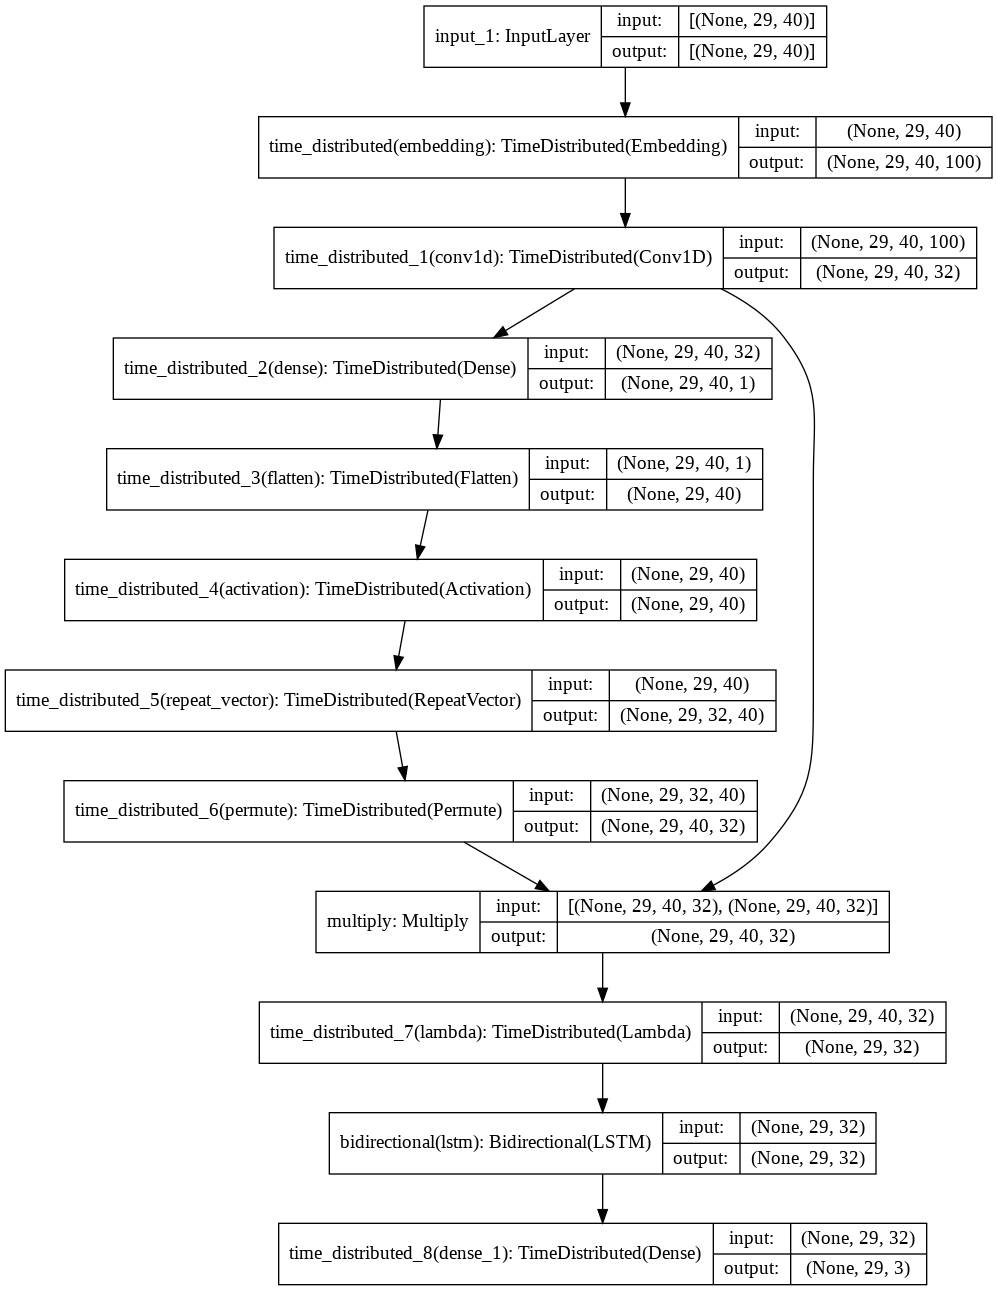

In [18]:
keras.utils.plot_model(model,show_shapes=True)

In [19]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


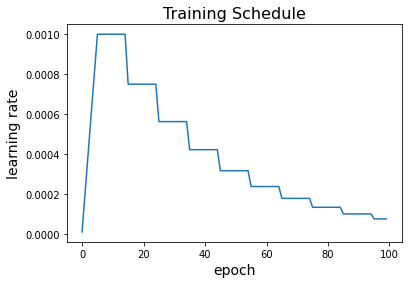

In [20]:
# CUSTOM LEARNING SCHEUDLE
# Reference: https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop
LR_START = 1e-5
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//10)
    return lr
    
lr2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(100)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Training Schedule',size=16); plt.show()

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
model.fit(x=padded_data_train,
          y=padded_labels_train,
          batch_size=64,
          epochs=50,
          callbacks=[es,lr2],
          validation_data=(padded_data_val, padded_labels_val),
          verbose=1)

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
469/469 [==============================] - 142s 233ms/step - loss: 1.0876 - accuracy: 0.7223 - val_loss: 1.0580 - val_accuracy: 0.8089
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000208.
469/469 [==============================] - 107s 228ms/step - loss: 0.5970 - accuracy: 0.8304 - val_loss: 0.3062 - val_accuracy: 0.8630
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000406.
469/469 [==============================] - 104s 222ms/step - loss: 0.3041 - accuracy: 0.8630 - val_loss: 0.2947 - val_accuracy: 0.8663
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0006039999999999999.
469/469 [==============================] - 104s 222ms/step - loss: 0.2914 - accuracy: 0.8674 - val_loss: 0.2871 - val_accuracy: 0.8691
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000802.
469/469 [==========================

In [23]:
model.save('attention_model.h5')

In [24]:
#read the unencoded test data
df_test = pd.read_csv('data/test.csv')
df_test.head()

,Unnamed: 0,story_id,sentence_id,sentence,label
0,205,10,0,huruma kenya we found barack obamas halfbro...,0
1,206,10,1,george obama says he is sure his halfbrother w...,1
2,207,10,2,george obama whose birth certificate shows tha...,0
3,208,10,3,in his memoir dreams for my father the democra...,1
4,209,10,4,in the book which is popular in nairobi and ca...,0


In [25]:
#prediction for one random instance

#select a random instance
random_story = df_test[df_test['story_id'] == random.choice(list(df_test.story_id.unique()))]

#preprocess the dataframe for the story_id and label
pad_enc_story = pad_encode_sentences(random_story)
pad_enc_story = np.array(pad_enc_story)

padded_labels_story = pad_labels(random_story)
padded_labels_story = padded_labels_story.reshape(-1, max_story_length, 1)

#predict 
yhat = model.predict(pad_enc_story)
yhat = np.argmax(yhat,axis=-1)
yhat_idx = np.where(yhat == 2)
pred_summary = pad_enc_story[yhat_idx]

print(yhat)
print(padded_labels_story.squeeze(axis=-1))

decoded_sentence = []

for i in range(len(pred_summary)):
  indexed_sentence = pred_summary[i]
  sentence = ' '.join([idx2word.get(idx) for idx in indexed_sentence if idx != 0 if idx2word.get(idx) is not None])
  decoded_sentence.append(sentence)

decoded_sentence


[[2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]]
[[2 2 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]]


['wired its fun to imagine what michael mapes studio must look like you would assume that the new yorkbased artists workspace has to resemble the lab of a harebrained entomologist with test tubes specimen bags and pushpins strewn about',
 'in reality of course to create the startlingly elaborate sculptural portraits mapes is known for he has to be much more organized than that it does take a fairly high degree of organization assures me but thats not the hardest']

In [26]:
#evaluating on whole set
#preprocess the entire test dataframe and the test labels
X_test = pad_encode_sentences(df_test)
X_test = np.array(X_test)

y_test = pad_labels(df_test)
y_test = y_test.squeeze(axis=-1)

#make predictions on the preprocessed data
y_test_pred = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred,axis=-1)

In [27]:
f1_score_macro = []
f1_score_micro = []
f1_score_weighted = []

for i in range(len(X_test)):
  f1_macro = f1_score(y_test[i],y_test_pred[i],average='macro')
  f1_micro = f1_score(y_test[i],y_test_pred[i],average='micro')
  f1_weighted = f1_score(y_test[i],y_test_pred[i],average='weighted')

  f1_score_macro.append(f1_macro)
  f1_score_micro.append(f1_micro)
  f1_score_weighted.append(f1_weighted)

df_f1_score = pd.DataFrame()
df_f1_score['f1_macro'] =  f1_score_macro
df_f1_score['f1_micro'] =  f1_score_micro
df_f1_score['f1_weight'] = f1_score_weighted

df_f1_score.head()

,f1_macro,f1_micro,f1_weight
0,0.730159,0.862069,0.825944
1,0.822660,0.896552,0.890946
2,0.750000,0.931034,0.922414
3,0.869048,0.931034,0.931034
4,0.777778,0.896552,0.896552


In [28]:
#get the submodel till the attention layer
sub_model = Model(inputs=model.layers[0].input, outputs=model.layers[5].output)

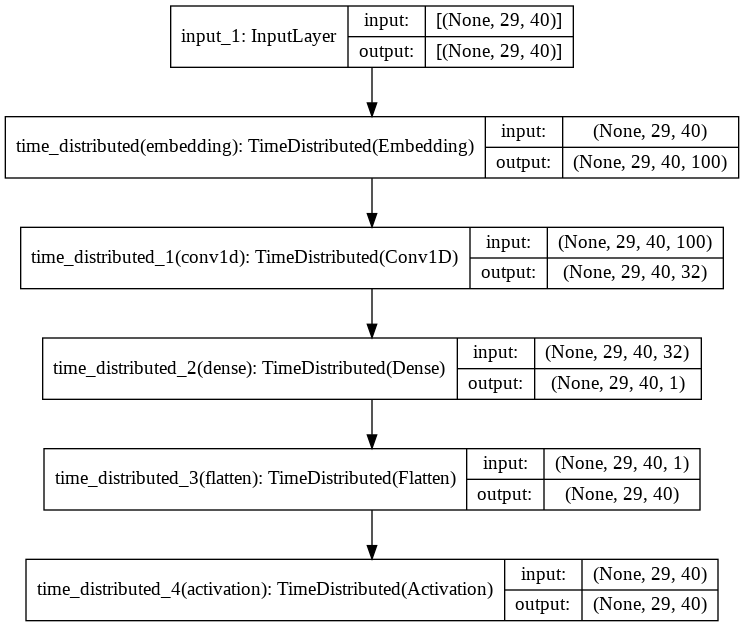

In [29]:
keras.utils.plot_model(sub_model,show_shapes=True)

In [30]:
#select a random instance
random_story = df_test[df_test['story_id'] == random.choice(list(df_test.story_id.unique()))]

#preprocess the dataframe for the story_id and label
x_enc_random = pad_encode_sentences(random_story)
x_enc_random = np.array(x_enc_random)

y_random = pad_labels(random_story)
y_random = y_random.reshape(-1, max_story_length, 1)

In [31]:
#use original model to get the final predictions
y_pred = model.predict(pad_enc_story)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)
print(y_pred.shape)

[[2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]]
(1, 29)


In [32]:
#use sub model to get the attention predictions
y_pred_att_weights = sub_model.predict(pad_enc_story)
print(y_pred_att_weights)
print(y_pred_att_weights.shape)

[[[0.02658757 0.02660767 0.02660939 ... 0.0262739  0.0260264  0.00373804]
  [0.02579126 0.02579133 0.02579144 ... 0.02579153 0.0257915  0.02565184]
  [0.02554973 0.02554356 0.02554497 ... 0.02555036 0.02554153 0.024992  ]
  ...
  [0.02497821 0.02497821 0.02497821 ... 0.02497821 0.02497821 0.02584985]
  [0.02497821 0.02497821 0.02497821 ... 0.02497821 0.02497821 0.02584985]
  [0.02497821 0.02497821 0.02497821 ... 0.02497821 0.02497821 0.02584985]]]
(1, 29, 40)


In [33]:
#get the index of summary candidates
summary_candidates_id = np.where(y_pred == 2)
summary_candidates_id

(array([0, 0]), array([0, 1]))

In [34]:
#get predicted values of summary candidates
summary_candidates = pad_enc_story[summary_candidates_id]
summary_candidates.shape

(2, 40)

In [35]:
#get the attention weights of summary candidates
att_weights_summary_candidates = y_pred_att_weights[summary_candidates_id]
att_weights_summary_candidates.shape

(2, 40)

In [38]:
# get one candidate randomly
idx = np.random.choice(len(summary_candidates), 1)

sentence = summary_candidates[idx]

weights = att_weights_summary_candidates[idx]

sentence.shape, weights.shape

((1, 40), (1, 40))

In [39]:
sentence

array([[ 69459, 120542, 104426,  31973, 149354,  32455, 147318, 140277,
         43696, 130142, 114211,  88690,  72125,  78888,  52390,  63284,
         62802, 149354,  13292,  97058,  96021, 106271, 147223, 147274,
         72489,  39931, 144918,      2,  48365,  64723,  36190, 104426,
        106265,   9445,  91031,  21081, 147292, 102863, 147318,  62424]],
      dtype=int32)

In [40]:
sentence_deocded = [idx2word.get(idx) for idx in sent[0]]
' '.join(sentence_deocded)

'wired its fun to imagine what michael mapes studio must look like you would assume that the new yorkbased artists workspace has to resemble the lab of a harebrained entomologist with test tubes specimen bags and pushpins strewn about PAD'

In [41]:
# create a temporary dataframe
df = pd.DataFrame()
df['words'] = (sentence_deocded)
df['attention_weights'] = weights.squeeze()

# filter out the top weights
df_sub = df.sort_values(by='attention_weights',ascending=False).head(10)
df_sub.head()

,words,attention_weights
37,strewn,0.025792
38,about,0.025792
19,artists,0.025791
2,fun,0.025791
36,pushpins,0.025791


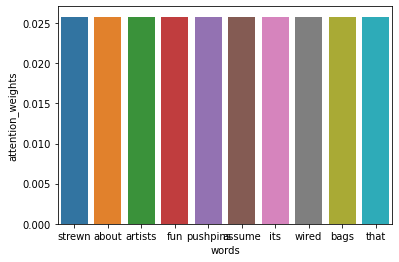

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.barplot(x="words", y="attention_weights", data=df_sub)
plt.show()